In [1]:
import numpy as np
%matplotlib inline

from devito import configuration
configuration['log-level'] = 'WARNING'

In [2]:
import scipy.io as sio
from scipy import signal
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from scipy.signal import convolve2d
from scipy.signal import correlate2d
from scipy.signal import fftconvolve
from scipy.signal import convolve
from scipy.signal import correlate

# Contoh membaca file .mat
#data = sio.loadmat("BG450_model.mat")
data = np.loadtxt('Model/Vp0 model DIX Vista INV NMO.txt')
#print(data.keys())
# Misalkan velocity model ada di key tertentu, misalnya 'velocity_model':
vp = data.T/1000
vp0 = np.loadtxt('Model/Vp0 model DIX Vista INV NMO.txt').T
vp0 = (vp0)/1000
vp0 = gaussian_filter(vp, [2, 2]) #velocity model intial

print(np.min(vp0))
print(np.max(vp0))

vp0.shape

1.5028287299923853
4.325784914675305


(1312, 264)

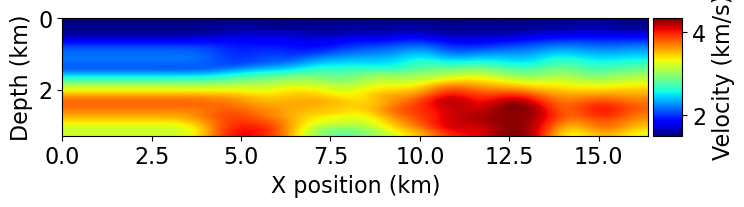

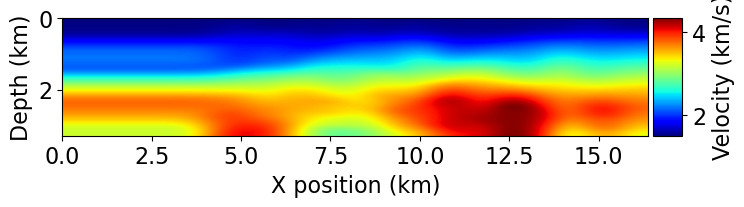

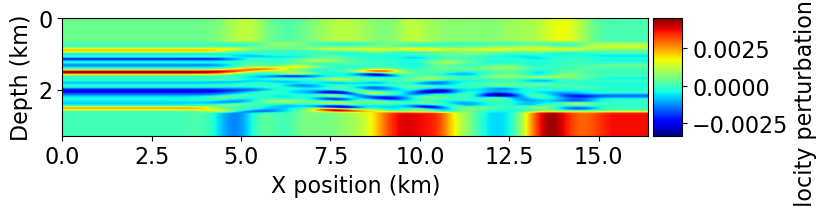

In [3]:
#NBVAL_IGNORE_OUTPUT
from examples.seismic import Model, plot_velocity, plot_perturbation, Receiver

# Define a physical size
shape = (vp0.shape)  # Number of grid point (nx, nz)
spacing = (12.5, 12.5)  # Grid spacing in m. The domain size is now 1km by 1km
origin = (0.,0.)  # What is the location of the top left corner. This is necessary to define
nboundary = 80
vmax_threshold = 4.5
vmin_threshold = 1.5

model = Model(vp=vp, origin=origin, shape=shape, spacing=spacing,
              space_order=2, nbl=nboundary, bcs="damp")

model0 = Model(vp=vp0, origin=origin, shape=shape, spacing=spacing,
              space_order=2, nbl=nboundary, bcs="damp", grid = model.grid)

plot_velocity(model)
plot_velocity(model0)
plot_perturbation(model0, model)

In [4]:
model.vp.data.shape

(1472, 424)

In [5]:
#NBVAL_IGNORE_OUTPUT
# Define acquisition geometry: source
from examples.seismic import AcquisitionGeometry, TimeAxis, RickerSource

#geometry define
#source geometry
nshots = 125  # Number of shots to create gradient from
shot_first_coordinate = 4050
shot_last_coordinate = 16450
shot_depth = 0

#receriver geometry
nreceivers = 160  # Number of receiver locations per shot 
first_channel_firstlreceriverline_coordinate = 0
last_channel_firstreceiverline_coordinate = 4050
receiverline_interval = 100
receiver_depth = 0



#recording define
t0 = 0.
tn = 4501. 
dt = model.critical_dt
timeAx = TimeAxis(start=t0, stop=tn, step=dt)


#source define
f0 = 0.015
shift_phase = 90



In [6]:
# First, position source centrally in all dimensions, then set depth
def geometry_and_source(nshots, shot_first_coordinate, shot_last_coordinate, shot_depth, nreceivers, first_channel_firstlreceriverline_coordinate, last_channel_firstreceiverline_coordinate, receiver_depth, receiverline_interval, t0, tn, dt, f0, shift_phase):
    src_coordinates = np.empty((nshots, 2))
    src_coordinates[:, 0] = np.linspace(shot_first_coordinate, shot_last_coordinate, nshots)
    src_coordinates[:, 1] = shot_depth  # Depth is 20m

    geometrys = []

    for i in range(nshots):
        # Define acquisition geometry: receivers

        # Initialize receivers for synthetic and imaging data
        rec_coordinates = np.empty((nreceivers, 2))
        rec_coordinates[:, 0] = np.linspace(first_channel_firstlreceriverline_coordinate+(i*receiverline_interval), last_channel_firstreceiverline_coordinate+(i*receiverline_interval), nreceivers)
        rec_coordinates[:, 1] = receiver_depth  # Depth is 20m

        # Geometry
        geometry = AcquisitionGeometry(model0, rec_coordinates, src_coordinates, t0, tn, f0=f0, src_type='Ricker', dt=dt)
        geometrys.append(geometry)


    t = np.arange(t0, tn+2, (dt))
    t = t/1000
    f0z = f0*1000
    t0 =   (1/f0z)
    st = (1 - (2*(np.pi**2)*(f0z**2)*(t-t0)**2))*(np.exp(-1*(np.pi**2)*(f0z**2)*(t-t0)**2))

    wavelet = st

    angle = shift_phase
    shifted = np.real(np.exp(1j*np.radians(angle)) * signal.hilbert(wavelet))
    shifted = np.array([shifted])
    shiftedT = shifted.T

    srcs = []

    for i in range(nshots):
        src = RickerSource(name='src', grid=model0.grid, f0=f0, time_range=timeAx)
        # First, position source centrally in all dimensions, then set depth
        src.coordinates.data[0, :] = src_coordinates[i, 0]
        src.coordinates.data[0, -1] = shot_depth  # Depth is 20m
        src.data[:] = shiftedT
        srcs.append(src)

    return geometrys, srcs

In [7]:
geometrys, srcs = geometry_and_source(nshots, shot_first_coordinate, shot_last_coordinate, shot_depth, nreceivers, first_channel_firstlreceriverline_coordinate, last_channel_firstreceiverline_coordinate, receiver_depth, receiverline_interval, t0, tn, dt, f0, shift_phase)

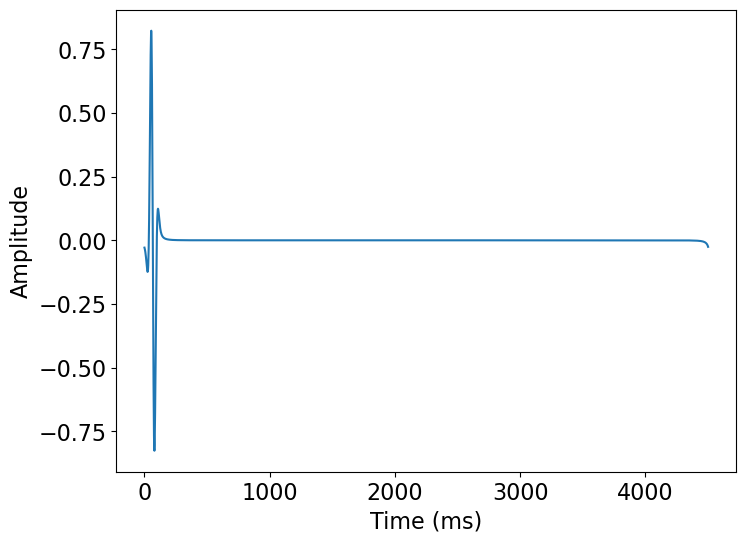

TimeAxis: start=0, stop=4502.11, step=1.769, num=2546


In [8]:
srcs[0].show()
srcs[0].data.shape

print(geometrys[0])
print(geometrys[0].time_axis)

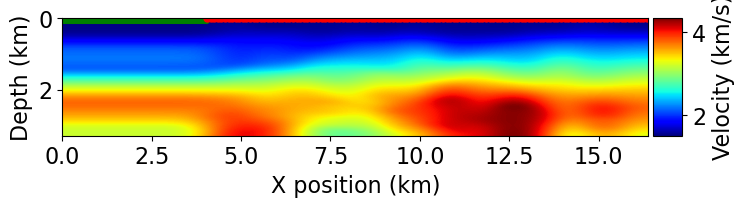

In [9]:
#NBVAL_IGNORE_OUTPUT
# Plot acquisition geometry
plot_velocity(model, source=geometrys[0].src_positions, receiver=geometrys[0].rec_positions)

In [10]:
# Mencari indeks geophone terdekat untuk setiap shot
geometry = geometrys[0]
nearest_indices = []
i=0
for shot in geometry.src_positions:
    distances = np.linalg.norm(geometrys[i].rec_positions - shot, axis=1)  # Hitung jarak Euclidean
    nearest_index = np.argmin(distances)  # Cari indeks dengan jarak minimum
    nearest_indices.append(nearest_index)
    i+=1

In [11]:
print(nearest_indices)

[159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159]


In [12]:
import segyio
import numpy as np
from collections import defaultdict

filename = 'Seismic Data/MarmousiAcousticInvisibleSurface.sgy'

# Dictionary untuk menyimpan shot gathers
shot_data = defaultdict(list)

with segyio.open(filename, "r", ignore_geometry=True) as segyfile:
    segyfile.mmap()
    n_traces = segyfile.tracecount
    n_samples = segyfile.samples.size
    
    # Ambil ID field record (shot number) per trace
    shot_ids = segyfile.attributes(segyio.TraceField.FieldRecord)[:]
    
    # Kelompokkan trace per shot
    for i in range(n_traces):
        shot_id = shot_ids[i]
        trace = segyfile.trace[i]
        shot_data[shot_id].append(trace)

# Ubah list trace per shot menjadi array (samples x trace)
shot_gathers = []
for shot_id, traces in shot_data.items():
    gather = np.stack(traces).T  # shape: (samples, traces)
    shot_gathers.append(gather)

# Contoh: akses shot ke-0
first_shot = shot_gathers[0]
print("Shape of first shot:", first_shot.shape)


Shape of first shot: (1126, 160)


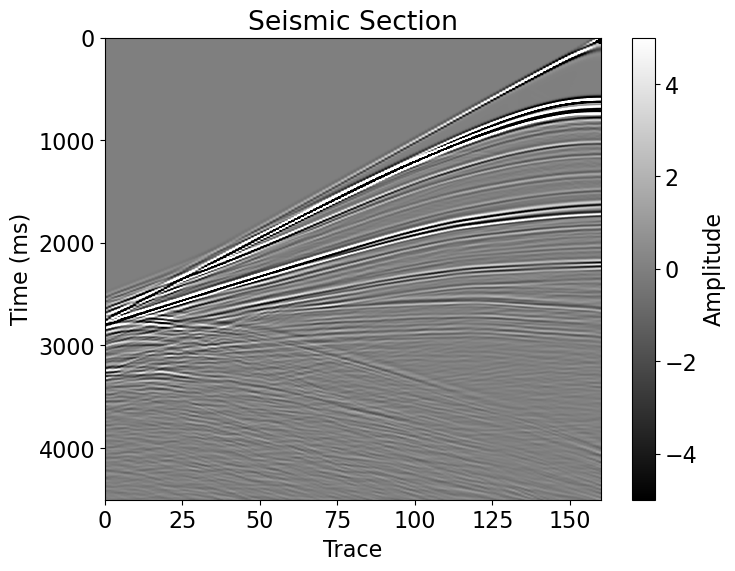

In [13]:
plt.imshow(shot_gathers[100], aspect='auto', cmap='gray', extent=[0, 160, 4504, 0], vmax=5, vmin=-5)
plt.xlabel('Trace')
plt.ylabel('Time (ms)')
plt.title('Seismic Section')
plt.colorbar(label='Amplitude')
plt.show()

In [14]:
import numpy as np
from scipy.signal import resample

# Example input
n_shot = 125
n_sample = 1126  # your actual number of samples
n_receiver = 160
dt_old = 4  # 4 ms
dt_new = dt  # 1.3 ms

# Example data (replace this with your actual seismic matrix)
data = np.array(shot_gathers)

# Compute new number of samples
duration = n_sample * dt_old
n_sample_new = int(duration / dt_new)

# Allocate output array
data_resampled = np.zeros((n_shot, n_sample_new, n_receiver))

# Resample each shot gather (along the sample/time axis)
for shot in range(n_shot):
    for rec in range(n_receiver):
        data_resampled[shot, :, rec] = resample(data[shot, :, rec], n_sample_new)


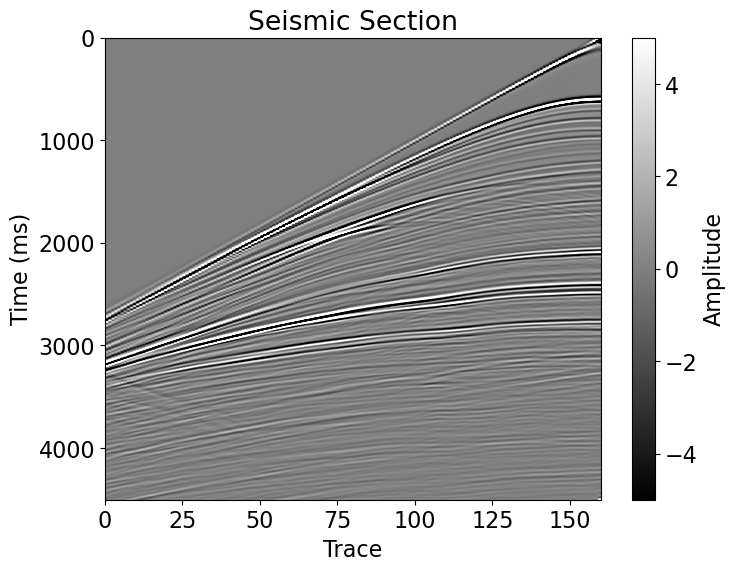

In [15]:
plt.imshow(data_resampled[0], aspect='auto', cmap='gray', extent=[0, 160, 4504, 0], vmax=5, vmin=-5)
plt.xlabel('Trace')
plt.ylabel('Time (ms)')
plt.title('Seismic Section')
plt.colorbar(label='Amplitude')
plt.show()

In [16]:
data_resampled[0].shape
#shot_gathers[0].shape

(2546, 160)

In [17]:
from devito import Eq, Operator

# Computes the residual between observed and synthetic data into the residual
def compute_residual(residual, dobs, dsyn, kg):
    if residual.grid.distributor.is_parallel:
        # If we run with MPI, we have to compute the residual via an operator
        # First make sure we can take the difference and that receivers are at the 
        # same position
        assert np.allclose(dobs.coordinates.data[:], dsyn.coordinates.data)
        assert np.allclose(residual.coordinates.data[:], dsyn.coordinates.data)
        # Create a difference operator
        diff_eq = Eq(residual, dsyn.subs({dsyn.dimensions[-1]: residual.dimensions[-1]}) -
                               dobs.subs({dobs.dimensions[-1]: residual.dimensions[-1]}))
        Operator(diff_eq)()
    else:
        # Data ukuran (1920 x 120)
        data_1 = dsyn.data[:]
        data_2 = dobs.data[:]

        # Data ukuran (1920 x 120)
        

        # Pastikan data_2 menjadi array 1D untuk keperluan konvolusi
        filter_data1 = dobs.data[:,kg]
        filter_data2 = dsyn.data[:,kg]


        for i in range(residual.data.shape[1]):
            # Panjang data asli
            len_data1 = len(data_1)

            # Panjang hasil korelasi
            len_full = len(convolve(filter_data1, data_1[:, i], mode='full'))

            # Indeks untuk mengambil nilai tengah
            start = (len_full - len_data1) // 2
            end = start + len_data1
            
            residual.data[:, i] = convolve(data_1[:, i], filter_data1, mode='full')[:len_data1] - convolve(data_2[:, i], filter_data2, mode='full')[:len_data1]
            
         # Data berukuran (1920 x 1)
        
        data_1 = dobs.data[:,kg]

        # Data berukuran (1920 x 120)
        data_2 = residual.data[:]    
        # Menyimpan hasil cross-correlation
        cross_correlations = []
        len_data = len(data_1)
        # Lakukan cross-correlation untuk setiap kolom di data_2
        for i in range(data_2.shape[1]):
            result = correlate(data_2[:, i], data_1, mode='full')[len_data-1:]
            cross_correlations.append(result)
        residual.data[:] = np.array(cross_correlations).T
        
        #residual.data[:] = ((residual.data[:] - residual.data[:].min())/(residual.data[:].max()-residual.data[:].min()))*((dobs.data[:].max()-dobs.data.min())+dobs.data.min())
    return residual

In [28]:
def misfit(vp_in):
    objective = 0.
    for i in range(nshots):
        # Compute synthetic data with forward operator 
        from examples.seismic.acoustic import AcousticWaveSolver

        solver = AcousticWaveSolver(model0, geometrys[i], space_order=2)
        
        # Create placeholders for the data residual and data
        residual = Receiver(name='residual', grid=model0.grid,
                            time_range=geometrys[i].time_axis, 
                            coordinates=geometrys[i].rec_positions)
        d_obs = Receiver(name='d_obs', grid=model.grid,
                         time_range=geometrys[i].time_axis, 
                         coordinates=geometrys[i].rec_positions)
        d_syn = Receiver(name='d_syn', grid=model0.grid,
                        time_range=geometrys[i].time_axis, 
                        coordinates=geometrys[i].rec_positions)
        # Update source location
        #geometry.src_positions[0, :] = src_coordinates[i, :]

        # Generate synthetic data from true model
        #_, _, _ = solver.forward(vp=model.vp, src=srcs[i], rec=d_obs)
        d_obs.data[:] = data_resampled[i]

        # Compute smooth data and full forward wavefield u0
        _, _, _ = solver.forward(vp=vp_in.vp, src=srcs[i], rec=d_syn)

        # Compute gradient from data residual and update objective function 
        compute_residual(residual, d_obs, d_syn, nearest_indices[i])
        objective += 0.5*norm(residual)**2
    return objective
    

In [19]:
def cubic_interpolation(alpha0, alpha1, f0, f1, df0, df1):
    """
    alpha0 = 0 (biasanya)
    alpha1 = nilai alpha awal (misal 1)
    f0, f1 = nilai fungsi misfit di alpha0 dan alpha1
    df0, df1 = arah turun di alpha0 dan alpha1 (dot product grad * direction)
    """

    d1 = df0 + df1 - 3 * ((f0 - f1) / (alpha0 - alpha1))
    d2 = np.sign(alpha1 - alpha0) * np.sqrt(d1**2 - df0 * df1)

    alpha_new = alpha1 - (alpha1 - alpha0) * (df1 + d2 - d1) / (df1 - df0 + 2*d2)
    alpha_new = max(0.1 * alpha1, min(alpha_new, 0.9 * alpha1))
    return alpha_new


def linesearch(vp_in, ff, g, p, a=0.0001, b=0.1, l=1, max_iter=5, max_l=5., min_l= 0.1, scale_l = 2):
    from copy import deepcopy
    from devito import mmax
    import numpy as np
    import time as tm

    ni = 0
    g_inner = g.data[nboundary:-nboundary, nboundary:-nboundary]/mmax(g)
    p_inner = p.data[nboundary:-nboundary, nboundary:-nboundary]/mmax(p)
    gtp = np.sum(g_inner * p_inner) # gradien awal dot arah
    best_l = 0
    best_ff2 = ff
    gtp_best = np.copy(gtp)
    g2_best = deepcopy(g)

    l_option = 0.
    ff_option = 0.
    g_option = deepcopy(g)
    g_option = deepcopy(g)


    while ni < max_iter:
        vp2 = deepcopy(vp_in)
        vp2.vp.data[:] = vp_in.vp.data[:] + (l) * (p.data[:]/mmax(p))
        vp2.vp.data[:] = np.clip(vp2.vp.data[:], vmin_threshold, vmax_threshold)

        start_time = tm.time()
        ff2, g2 = fwi_gradient(vp2.vp)
        end_time = tm.time()

        print(f"Waktu eksekusi: {end_time - start_time:.2f} detik")
        
        g2.data[:] *= -1
        g2_inner = g2.data[nboundary:-nboundary, nboundary:-nboundary]/mmax(g2)
        g2tp = np.sum(g2_inner[:] * p_inner)

        if l == 0:
            l = min_l

        if ff2 > ff:
            p.data[:] = deepcopy(g.data[:])
            p.data[:] *= -1

        if ff2 < ff :
           l_option = deepcopy(l)
           ff_option = deepcopy(ff2)
           g_option = deepcopy(g)

        # Cek sufficient decrease (Armijo)
        print(f"ff2 = {ff2}, ff + a * l * gtp = {ff + a * l * gtp}, a*l*gtp = {a*l*gtp}")
        print(f"abs(g2tp) = {abs(g2tp)}, abs(b*gtp) = {abs(b*gtp)}")
        print(f"g2tp = {(g2tp)}, (b*gtp) = {(b*gtp)}")
        print(" ")
        if ff2 <= ff + a * l * gtp:
            # Simpan sebagai kandidat terbaik jika Armijo terpenuhi
            if best_l == 0 or ff2 < best_ff2:
                best_l = l
                best_ff2 = ff2
                gtp_best = deepcopy(g2tp)
                g2_best.data[:] = g2.data[:]

            # Cek curvature condition
            if (g2tp) >= (b * gtp):
                print(f"Strong Wolfe satisfied, l best : {l}")
                best_l = l
                best_ff2 = ff2
                gtp_best = deepcopy(g2tp)
                g2_best.data[:] = g2.data[:]

                return best_l, best_ff2, g2_best  # Strong Wolfe satisfied
            else:
                if l >= max_l:
                    l = cubic_interpolation(0, l, ff, ff2, gtp, g2tp)
                    print(f"Armijo satisfied but curvature not satisfied and l>{max_l}, l update : {l}")
                else:
                  l *= scale_l
                  print(f"Armijo satisfied but curvature not satisfied, l update : {l}")
        else:
          if ff2 < ff :
            if (g2tp) >= (b * gtp):
               l*=scale_l
               print(f"Armijo not satisfied, ff2 < ff, but curvature satisfied l update : {l}")
            else :
               l = cubic_interpolation(0, l, ff, ff2, gtp, g2tp)
               print(f"Armijo not satisfied, ff2<ff, curvature not satisfied l update : {l}")
          else:
                l = cubic_interpolation(0, l, ff, ff2, gtp, g2tp)
                print(f"nether wolve satisfied and l>{max_l}, l update : {l}")
        ni += 1
        
    if best_l != 0 :
        print(f"Strong Wolfe not satisfied. Returning best Armijo-satisfying l : {best_l}")
        return best_l, best_ff2, g2_best
    else:
        if (l_option == 0):
            best_l = cubic_interpolation(0, l, ff, ff2, gtp, g2tp)
            vp2 = deepcopy(vp_in)
            vp2.vp.data[:] = vp_in.vp.data[:] + (l) * (p.data[:]/mmax(p))
            vp2.vp.data[:] = np.clip(vp2.vp.data[:], vmin_threshold, vmax_threshold)
            ff2, g2 = fwi_gradient(vp2.vp)
            best_ff2 = deepcopy(ff2)
            g2_best = deepcopy(g2)
            print(f"No condition satisfied. Returning l interpolated : {best_l}")
        else :
           best_l = deepcopy(l_option)
           best_ff2 = deepcopy(ff_option)
           g2_best = deepcopy(g_option)
        return best_l, best_ff2, g2_best


def cg(g0, g1, p):
  g0_inner = g0[nboundary:-nboundary, nboundary:-nboundary]
  g1_inner = g1[nboundary:-nboundary, nboundary:-nboundary]
  B = np.sum(g0_inner*g1_inner)/np.sum(g0_inner*g0_inner)
  p = -1*g1 + B*p
  print(B)
  return p


def cg_pr(g0, g1, p):
    g0_inner = g0[nboundary:-nboundary, nboundary:-nboundary]
    g1_inner = g1[nboundary:-nboundary, nboundary:-nboundary]
    y = g1_inner - g0_inner
    B = np.sum(g1_inner * y) / np.sum(g0_inner * g0_inner)
    if B < 0:
        B = 0  # Reset jika tidak descent
    p = -1 * g1[:] + B * p

    print(B)
    return p

def cg_hs(g0, g1, p):
    g0_inner = g0.data[nboundary:-nboundary, nboundary:-nboundary]
    g1_inner = g1.data[nboundary:-nboundary, nboundary:-nboundary]
    p_inner = p.data[nboundary:-nboundary, nboundary:-nboundary]
    y = g1_inner - g0_inner
    denom = np.sum(p_inner * y)
    if denom == 0:
        B = 0  # Hindari pembagian nol
    else:
        B = np.sum(g1_inner * y) / denom
    if B < 0:
        B = 0  # Reset jika arah tidak descent
    p.data[:] = -1 * g1.data[:] + B * p.data[:]

    print(f"Nilai B : {B}")
    return p

from examples.seismic.acoustic import AcousticWaveSolver

solver = AcousticWaveSolver(model, geometrys[0], space_order=4)

d_obs = Receiver(name='d_obs', grid=model.grid,
                         time_range=geometrys[0].time_axis, 
                         coordinates=geometrys[0].rec_positions)

_, _, _ = solver.forward(vp=model.vp, src=srcs[0], rec=d_obs)

from examples.seismic import plot_shotrecord

# Plot shot record for true and smooth velocity model and the difference
plot_shotrecord(d_obs.data, model, t0, tn)

d_obs.data.shape

print(np.max(shot_gathers[0]), np.min(shot_gathers[100]))

plt.imshow(d_obs.data, aspect='auto', cmap='gray', extent=[0, 160, 4504, 0], vmax=-1, vmin=1)
plt.xlabel('Trace')
plt.ylabel('Time (ms)')
plt.title('Seismic Section')
plt.colorbar(label='Amplitude')
plt.show()

print(np.max(d_obs.data), np.min(d_obs.data))

In [20]:
from devito import Function, mmax
from examples.seismic.acoustic import AcousticWaveSolver
from examples.seismic import Receiver
from devito import norm
import numpy as np

def fwi_gradient_per_shot(i, model0, geometrys, srcs, data_resampled, nearest_indices, vp_in):

    grad = Function(name="grad", grid=model.grid)
    
    solver = AcousticWaveSolver(model0, geometrys[i], space_order=2)
    
    residual = Receiver(name='residual', grid=model0.grid,
                        time_range=geometrys[i].time_axis, 
                        coordinates=geometrys[i].rec_positions)
    d_obs = Receiver(name='d_obs', grid=model0.grid,
                     time_range=geometrys[i].time_axis, 
                     coordinates=geometrys[i].rec_positions)
    d_syn = Receiver(name='d_syn', grid=model0.grid,
                    time_range=geometrys[i].time_axis, 
                    coordinates=geometrys[i].rec_positions)

    d_obs.data[:] = data_resampled[i]
    
    _, u0, _ = solver.forward(vp=vp_in, save=True, src=srcs[i], rec=d_syn)

    compute_residual(residual, d_obs, d_syn, nearest_indices[i])
    
    phi = .5 * norm(residual)**2
    
    solver.gradient(rec=residual, u=u0, vp=vp_in, grad=grad)
    
    return phi, grad.data




import multiprocessing as mp

num_workers = 3  # atur jumlah core di sini


def fwi_gradient_parallel(vp_in):
    with mp.Pool(processes=num_workers) as pool:
        results = pool.starmap(
            fwi_gradient_per_shot,
            [(i, model0, geometrys, srcs, data_resampled, nearest_indices, vp_in)
             for i in range(nshots)]
        )
    
    grad = Function(name="grad", grid=model0.grid)
    gradNormalized = Function(name="gradNormalized", grid=model0.grid)
    total_phi = 0.0

    for phi_i, grad_i in results:
        grad.data[:] += grad_i
        total_phi += phi_i

    grad.data[:] *= watermute.data[:]
    grad.data[:] *= modelpadmute.data[:]

    gradNormalized.data[:] = grad.data[:]/mmax(grad)

    return total_phi, gradNormalized


In [27]:
# Create FWI gradient kernel 
from devito import Function, TimeFunction, norm, mmax

from examples.seismic import Receiver, plot_shotrecord

import scipy
def fwi_gradient(vp_in):    
    # Create symbols to hold the gradient
    grad = Function(name="grad", grid=model.grid)
    
    objective = 0.
    for i in range(nshots):
        # Compute synthetic data with forward operator 
        from examples.seismic.acoustic import AcousticWaveSolver

        solver = AcousticWaveSolver(model0, geometrys[i], space_order=2)
        
        # Create placeholders for the data residual and data
        residual = Receiver(name='residual', grid=model.grid,
                            time_range=geometrys[i].time_axis, 
                            coordinates=geometrys[i].rec_positions)
        d_obs = Receiver(name='d_obs', grid=model.grid,
                         time_range=geometrys[i].time_axis, 
                         coordinates=geometrys[i].rec_positions)
        d_syn = Receiver(name='d_syn', grid=model.grid,
                        time_range=geometrys[i].time_axis, 
                        coordinates=geometrys[i].rec_positions)

        
        # Update source location
        #geometry.src_positions[0, :] = src_coordinates[i, :]

        # Generate synthetic data from true model
        #_, _, _ = solver.forward(vp=model.vp, src=srcs[0i, rec=d_obs)
        d_obs.data[:] = data_resampled[i]

        # Compute smooth data and full forward wavefield u0
        _, u0, _ = solver.forward(vp=vp_in, save=True, src=srcs[i], rec=d_syn)
        
        #plot_shotrecord(d_syn.data[:], model0, t0,tn)
        # Compute gradient from data residual and update objective function 
        compute_residual(residual, d_obs, d_syn, nearest_indices[i])
        
        objective += .5*norm(residual)**2
        
        #plot_shotrecord(residual.data, model, t0, tn)
        solver.gradient(rec=residual, u=u0, vp=vp_in, grad=grad)
        
        
    gradNormalized = Function(name="gradNormalized", grid=model.grid)
    grad.data[:] *= watermute.data[:]
    grad.data[:] *= modelpadmute.data[:]
    #Normalisasi ke rentang [-1, 1]
    gradNormalized.data[:] = grad.data[:]
    
        

    return objective, gradNormalized

In [22]:
waterheight = 36
watermute = Function(name="watermute", grid=model.grid)
watermute.data[:,nboundary+waterheight:] += 1

In [23]:
modelpad = 160
modelpadmute = Function(name="modelpadmute", grid=model.grid)
modelpadmute.data[nboundary+modelpad:,:] += 1
#modelpadmute.data[280-(nboundary+modelpad):280,:] = 0

In [ ]:
from copy import deepcopy
from devito import mmax
import time as tm

multiscale_freq = np.array([5., 10., 15.])
multiscale_freq /= 1000

modelbest_each_freq = []

misfiti = []

update_model = Model(vp=vp0, origin=origin, shape=shape, spacing=spacing,
            space_order=2, nbl=nboundary, bcs="damp", grid = model.grid)

#update_model.vp.data[:] = np.loadtxt("Best Model 5 Hz.txt")


for k in multiscale_freq:
    print(f"Proses FWI freq {k}")

    geometrys, srcs = geometry_and_source(nshots, shot_first_coordinate, shot_last_coordinate, shot_depth, nreceivers, first_channel_firstlreceriverline_coordinate, last_channel_firstreceiverline_coordinate, receiver_depth, receiverline_interval, t0, tn, dt, k, shift_phase)
    

    # Mencari indeks geophone terdekat untuk setiap shot
    geometry = geometrys[0]
    nearest_indices = []
    i1=0
    
    for shot in geometry.src_positions:
        distances = np.linalg.norm(geometrys[i1].rec_positions - shot, axis=1)  # Hitung jarak Euclidean
        nearest_index = np.argmin(distances)  # Cari indeks dengan jarak minimum
        nearest_indices.append(nearest_index)
        i1+=1
    
    
    modeli =[]
    gradi = []
    #plot_velocity(update_model)
    model_update = deepcopy(update_model.vp.data[:])
    modeli.append(model_update)

    fwi_iterations = 5  # Number of outer FWI iteration
    fwi_index = 0
    for i in range(fwi_iterations):
        if i==0 :
            start_time = tm.time()
            
            ff, update = fwi_gradient(update_model.vp)
            
            end_time = tm.time()

            print("")
            print(f"Waktu eksekusi: {end_time - start_time:.2f} detik")
            print("")
            

            gradient = deepcopy(update)
            gradient.data[:] *= -1

        else :
            ff, update1 = FF, G

            gradient1 = deepcopy(update1)
            gradient1.data[:] *= -1

            update = cg_hs(gradient, gradient1, update)

            if np.sum(gradient1.data[:]*update.data[:]) >= 0:
                update.data[:] = deepcopy(gradient1.data[:])
                update.data[:] *= -1
      
            gradient = deepcopy(gradient1)

        print(f"Maksimum p : {np.max(update.data)}")
        print(f"Minimum p : {np.min(update.data)}")
        print(f"Norm P : {np.linalg.norm(update.data)}")


        misfit_model = deepcopy(ff)
        misfiti.append(misfit_model)

        updatei = deepcopy(update.data[:])
        gradi.append(updatei)


        print(f" ")
        print(f"===========================================================")
        print(f"FWI freq {k} iterasi ke-{fwi_index}/{fwi_iterations} : {ff}")
    

        L, FF, G = linesearch(update_model, ff, gradient, update, a=0.0001, b=0.1, l=1, max_iter=5, max_l = 5, scale_l=2) 

    
        update_model.vp.data[:] += ((L/mmax(update)))*update.data[:]
        update_model.vp.data[:] = np.clip(update_model.vp.data[:], vmin_threshold, vmax_threshold)

        model_update = deepcopy(update_model.vp.data[:])
        modeli.append(model_update)
    
        fwi_index+=1
    
    ff = misfit(update_model)
    misfit_model = deepcopy(ff)
    misfiti.append(misfit_model)

    print(f" ")
    print(f"===========================================================")
    print(f"FWI freq {k} iterasi ke-{fwi_index}/{fwi_iterations} : {ff}")

    best_model = deepcopy(update_model.vp.data[:])

    modelbest_each_freq.append(best_model)

    np.savetxt(f'Model_Progres/Best Model {k*1000} Hz.txt', best_model)
    np.save(f'Model_Progres/Update Model {k*1000} Hz.npy', modeli)
    np.save(f'Model_Progres/Gradient Model {k*1000} Hz.npy', gradi)

    xmin = (origin[0]*spacing[0])/1000
    zmin = (origin[1]*spacing[1])/1000
    xmax = (origin[0]*spacing[0] + shape[0]*spacing[0])/1000
    zmax = (origin[1]*spacing[1] + shape[1]*spacing[1])/1000
    plt.imshow(update_model.vp.data[nboundary:nboundary+shape[0], nboundary:nboundary+shape[1]].T, extent=[xmin, xmax, zmax, zmin], cmap='jet', vmin=1.5, vmax=4.5, aspect='auto')
    plt.colorbar()
    plt.xlabel("X (km)")
    plt.ylabel("Z (km)")
    plt.show()

Proses FWI freq 0.005


In [33]:
print(len(modelbest_each_freq))

3


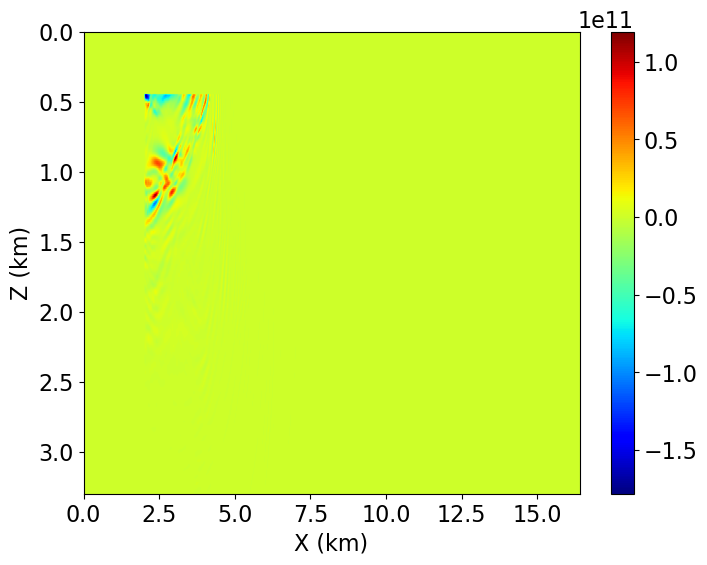

-178266830000.0


In [41]:
import matplotlib.pyplot as plt

xmin = (origin[0]*spacing[0])/1000
zmin = (origin[1]*spacing[1])/1000
xmax = (origin[0]*spacing[0] + shape[0]*spacing[0])/1000
zmax = (origin[1]*spacing[1] + shape[1]*spacing[1])/1000
plt.imshow(update.data[nboundary:nboundary+shape[0], nboundary:nboundary+shape[1]].T, extent=[xmin, xmax, zmax, zmin], cmap='jet', aspect='auto')
plt.colorbar()
plt.xlabel("X (km)")
plt.ylabel("Z (km)")
plt.show()

print(update.data.min())

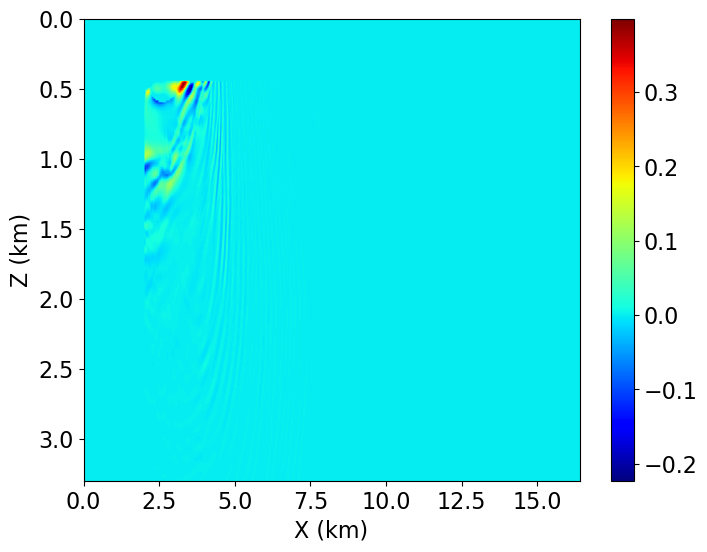

In [39]:
selisih_model1 = Model(vp=vp0, origin=origin, shape=shape, spacing=spacing,
              space_order=2, nbl=nboundary, bcs="damp", grid = model.grid)
selisih_model1.vp.data[:] = modelbest_each_freq[1][:] - modelbest_each_freq[0][:]
xmin = (origin[0]*spacing[0])/1000
zmin = (origin[1]*spacing[1])/1000
xmax = (origin[0]*spacing[0] + shape[0]*spacing[0])/1000
zmax = (origin[1]*spacing[1] + shape[1]*spacing[1])/1000
plt.imshow(selisih_model1.vp.data[nboundary:nboundary+shape[0], nboundary:nboundary+shape[1]].T, extent=[xmin, xmax, zmax, zmin], cmap='jet', aspect='auto')
plt.colorbar()
plt.xlabel("X (km)")
plt.ylabel("Z (km)")
plt.show()

In [42]:
np.max(selisih_model1.vp.data[:])
np.min(selisih_model1.vp.data[:])

Data(-0.22307384, dtype=float32)

In [50]:
import numpy as np

# Load file .npy
Gradient_check = np.load('Gradient Model 15.0 Hz.npy')

# Cek hasilnya
print(Gradient_check.shape)

(5, 1472, 424)


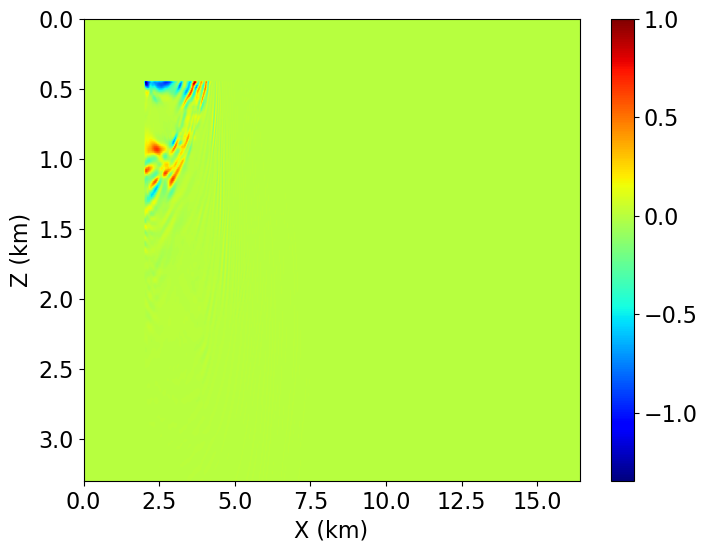

-178266830000.0


In [51]:
import matplotlib.pyplot as plt
Gradient_Dummy = deepcopy(update)
Gradient_Dummy.data[:] = Gradient_check[0]
Gradient_Dummy.data[:] /= mmax(Gradient_Dummy)

xmin = (origin[0]*spacing[0])/1000
zmin = (origin[1]*spacing[1])/1000
xmax = (origin[0]*spacing[0] + shape[0]*spacing[0])/1000
zmax = (origin[1]*spacing[1] + shape[1]*spacing[1])/1000
plt.imshow(Gradient_Dummy.data[nboundary:nboundary+shape[0], nboundary:nboundary+shape[1]].T, extent=[xmin, xmax, zmax, zmin], cmap='jet', aspect='auto')
plt.colorbar()
plt.xlabel("X (km)")
plt.ylabel("Z (km)")
plt.show()

print(update.data.min())

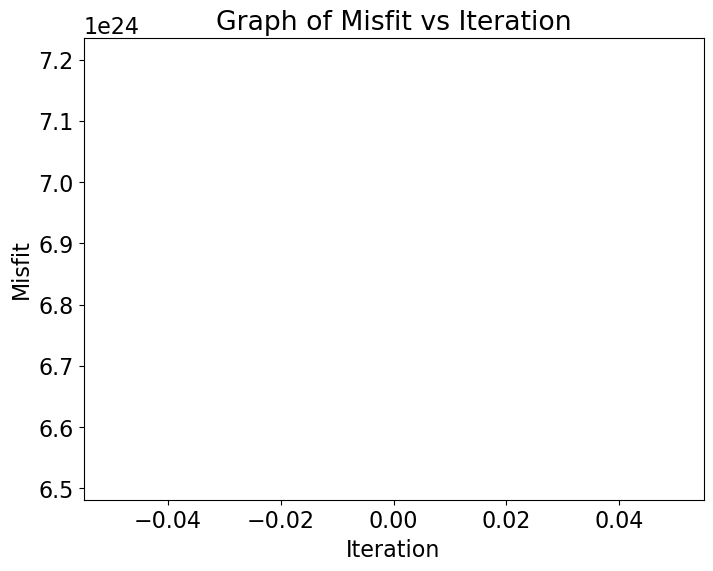

In [25]:
import matplotlib.pyplot as plt

plt.plot(misfiti)
plt.title("Graph of Misfit vs Iteration")
plt.xlabel("Iteration")
plt.ylabel("Misfit")
plt.show()

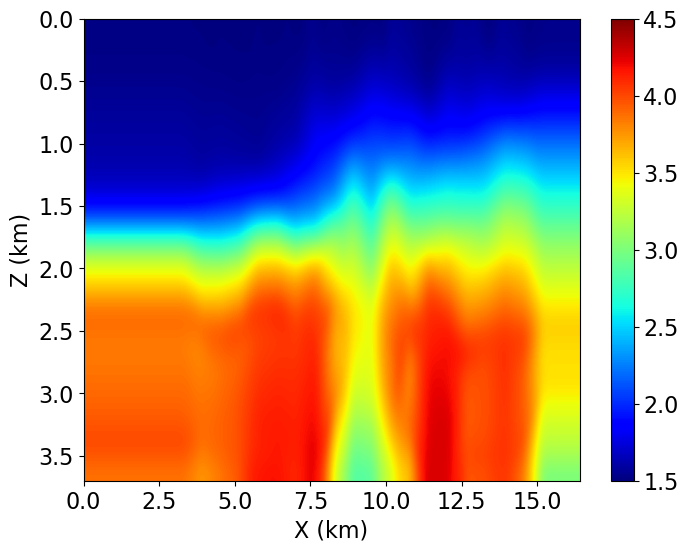

In [26]:
xmin = (origin[0]*spacing[0])/1000
zmin = (origin[1]*spacing[1])/1000
xmax = (origin[0]*spacing[0] + shape[0]*spacing[0])/1000
zmax = (origin[1]*spacing[1] + shape[1]*spacing[1])/1000
plt.imshow(model0.vp.data[nboundary:nboundary+shape[0], nboundary:nboundary+shape[1]].T, extent=[xmin, xmax, zmax, zmin], cmap='jet', vmin=1.5, vmax=4.5, aspect='auto')
plt.colorbar()
plt.xlabel("X (km)")
plt.ylabel("Z (km)")
plt.show()

In [27]:
xmin = (origin[0]*spacing[0])/1000
zmin = (origin[1]*spacing[1])/1000
xmax = (origin[0]*spacing[0] + shape[0]*spacing[0])/1000
zmax = (origin[1]*spacing[1] + shape[1]*spacing[1])/1000
plt.imshow(modelbest_each_freq[0][nboundary:nboundary+shape[0], nboundary:nboundary+shape[1]].T, extent=[xmin, xmax, zmax, zmin], cmap='jet', vmin=1.5, vmax=4.5, aspect='auto')
plt.colorbar()
plt.xlabel("X (km)")
plt.ylabel("Z (km)")
plt.show()

IndexError: list index out of range

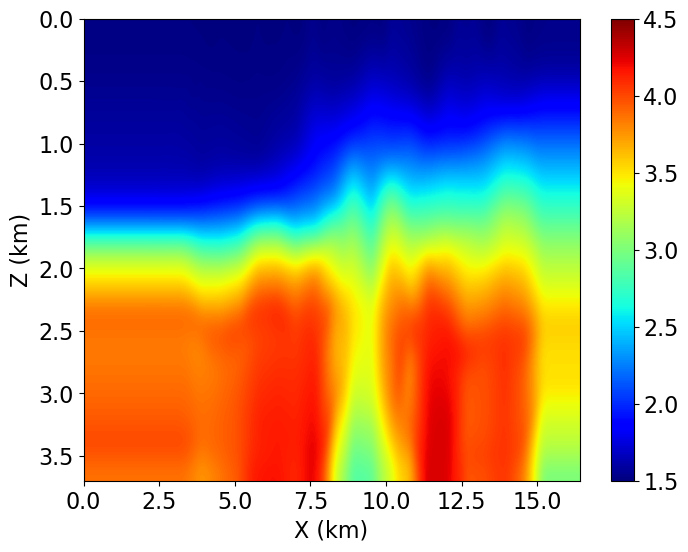

In [43]:

xmin = (origin[0]*spacing[0])/1000
zmin = (origin[1]*spacing[1])/1000
xmax = (origin[0]*spacing[0] + shape[0]*spacing[0])/1000
zmax = (origin[1]*spacing[1] + shape[1]*spacing[1])/1000
plt.imshow(update_model.vp.data[nboundary:nboundary+shape[0], nboundary:nboundary+shape[1]].T, extent=[xmin, xmax, zmax, zmin], cmap='jet', vmin=1.5, vmax=4.5, aspect='auto')
plt.colorbar()
plt.xlabel("X (km)")
plt.ylabel("Z (km)")
plt.show()

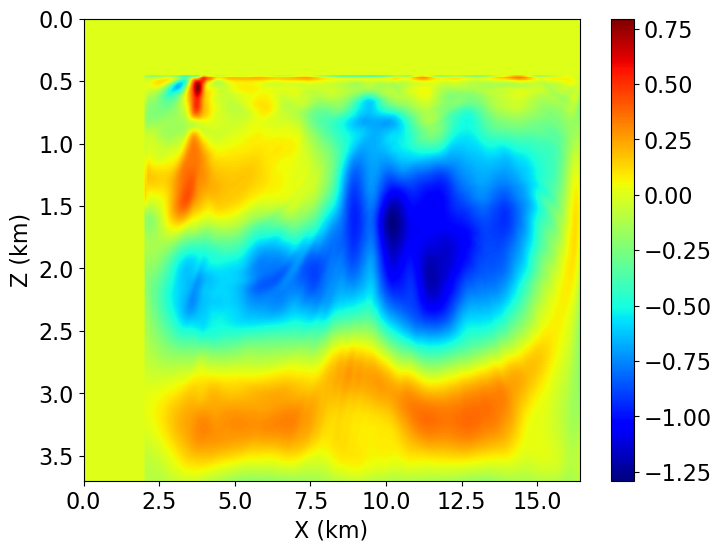

In [36]:
selisih_model = Model(vp=vp0, origin=origin, shape=shape, spacing=spacing,
              space_order=2, nbl=nboundary, bcs="damp", grid = model.grid)
selisih_model.vp.data[:] = update_model.vp.data[:] - model0.vp.data[:]
xmin = (origin[0]*spacing[0])/1000
zmin = (origin[1]*spacing[1])/1000
xmax = (origin[0]*spacing[0] + shape[0]*spacing[0])/1000
zmax = (origin[1]*spacing[1] + shape[1]*spacing[1])/1000
plt.imshow(selisih_model.vp.data[nboundary:nboundary+shape[0], nboundary:nboundary+shape[1]].T, extent=[xmin, xmax, zmax, zmin], cmap='jet', aspect='auto')
plt.colorbar()
plt.xlabel("X (km)")
plt.ylabel("Z (km)")
plt.show()

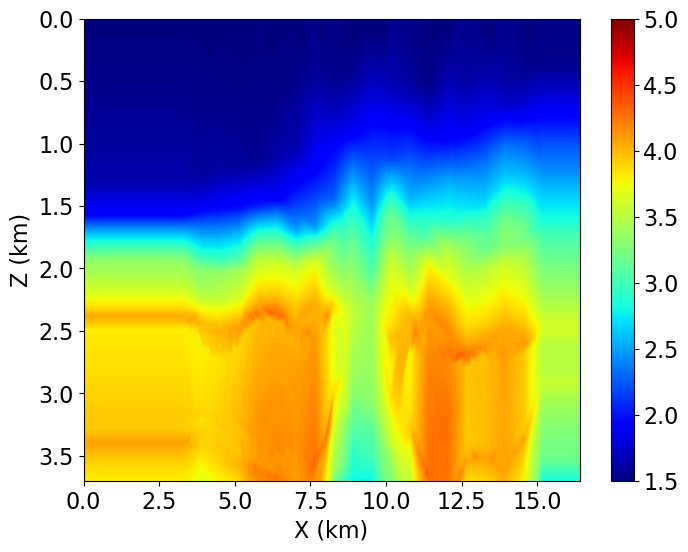

In [37]:
xmin = (origin[0]*spacing[0])/1000
zmin = (origin[1]*spacing[1])/1000
xmax = (origin[0]*spacing[0] + shape[0]*spacing[0])/1000
zmax = (origin[1]*spacing[1] + shape[1]*spacing[1])/1000
plt.imshow(model.vp.data[nboundary:nboundary+shape[0], nboundary:nboundary+shape[1]].T, extent=[xmin, xmax, zmax, zmin], cmap='jet', vmin=1.5, vmax=5.0, aspect='auto')
plt.colorbar()
plt.xlabel("X (km)")
plt.ylabel("Z (km)")
plt.show()

In [41]:
geometrys[124].src_positions
geometrys[0].rec_positions[0]


array([0., 0.])

In [43]:
recs_coordinate = []

for i in range(nshots):
    recs_coordinate.append(geometrys[i].rec_positions)

In [44]:
recs_coordinate[0]

array([[   0.        ,    0.        ],
       [  25.47169811,    0.        ],
       [  50.94339623,    0.        ],
       [  76.41509434,    0.        ],
       [ 101.88679245,    0.        ],
       [ 127.35849057,    0.        ],
       [ 152.83018868,    0.        ],
       [ 178.30188679,    0.        ],
       [ 203.77358491,    0.        ],
       [ 229.24528302,    0.        ],
       [ 254.71698113,    0.        ],
       [ 280.18867925,    0.        ],
       [ 305.66037736,    0.        ],
       [ 331.13207547,    0.        ],
       [ 356.60377358,    0.        ],
       [ 382.0754717 ,    0.        ],
       [ 407.54716981,    0.        ],
       [ 433.01886792,    0.        ],
       [ 458.49056604,    0.        ],
       [ 483.96226415,    0.        ],
       [ 509.43396226,    0.        ],
       [ 534.90566038,    0.        ],
       [ 560.37735849,    0.        ],
       [ 585.8490566 ,    0.        ],
       [ 611.32075472,    0.        ],
       [ 636.79245283,   

In [50]:
recs_coordinate = np.array(recs_coordinate)
srcs_coordinate = np.array(geometrys[0].src_positions)

In [47]:
recs_coordinate.shape

(125, 160, 2)

In [51]:
import matplotlib.pyplot as plt

# Misalnya bentuk array kamu:
# receiver_coords shape: (nshot, nreceiver, 2)
# source_coords shape: (nshot, 2)

def plot_shot_gather(receiver_coords, source_coords, shot_idx):
    # Ambil koordinat untuk satu shot
    recs = receiver_coords[shot_idx]  # shape: (nreceiver, 2)
    src = source_coords[shot_idx]     # shape: (2,)

    plt.figure(figsize=(10, 5))
    plt.scatter(recs[:, 0], recs[:, 1], c='blue', label='Receiver', marker='v')
    plt.scatter(src[0], src[1], c='red', label='Source', marker='*', s=100)
    plt.title(f'Shot {shot_idx}')
    plt.xlabel('X')
    plt.ylabel('Z')
    plt.gca().invert_yaxis()  # karena Z biasanya ke bawah dalam data seismik
    plt.legend()
    plt.grid(True)
    plt.show()


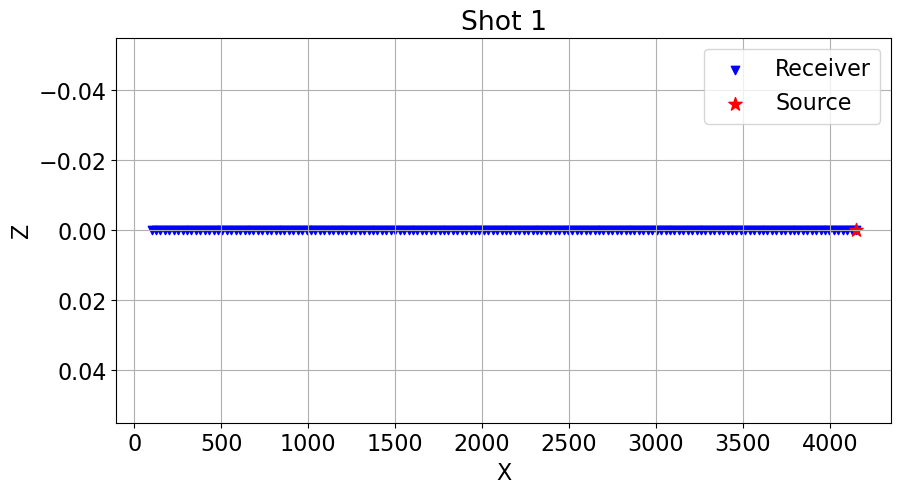

In [52]:
plot_shot_gather(recs_coordinate, srcs_coordinate, 1)

In [53]:
import matplotlib.pyplot as plt

def plot_all_shots(receiver_coords, source_coords):
    nshot = source_coords.shape[0]

    plt.figure(figsize=(12, 6))

    for shot in range(nshot):
        recs_x = receiver_coords[shot, :, 0]  # ambil hanya x receiver
        shot_num = [shot] * len(recs_x)       # y-nya: nomor shot yang sama

        # plot receiver
        plt.scatter(recs_x, shot_num, color='blue', s=5, label='Receiver' if shot == 0 else "")

        # plot source
        plt.scatter(source_coords[shot, 0], shot, color='red', marker='*', s=30, label='Source' if shot == 0 else "")

    plt.xlabel('X Coordinate')
    plt.ylabel('Shot Number')
    plt.title('Source & Receiver Coordinates per Shot')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


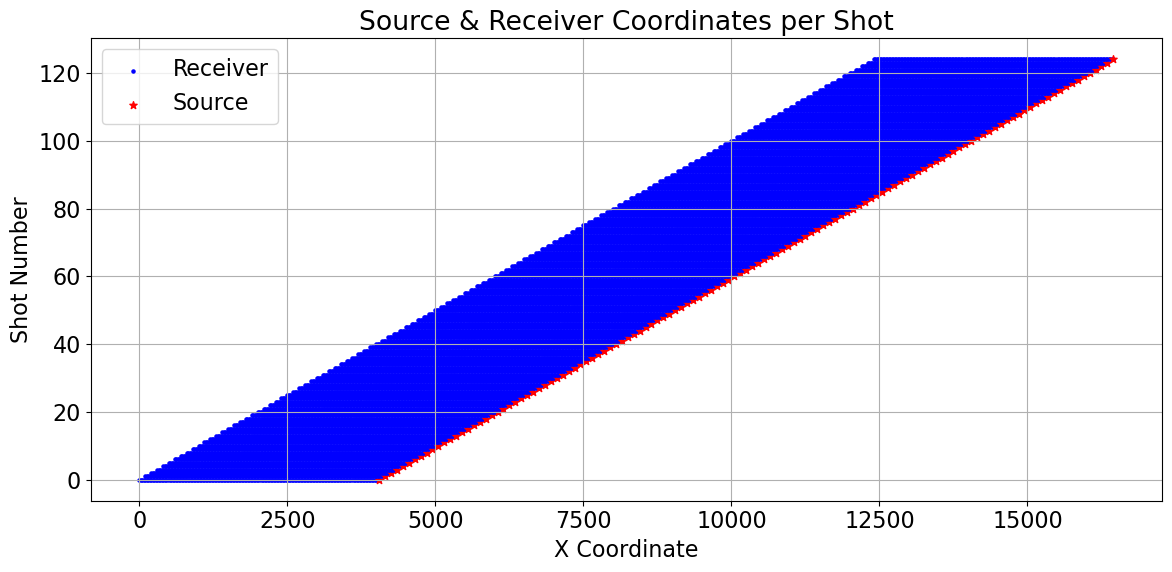

In [54]:
plot_all_shots(recs_coordinate, srcs_coordinate)

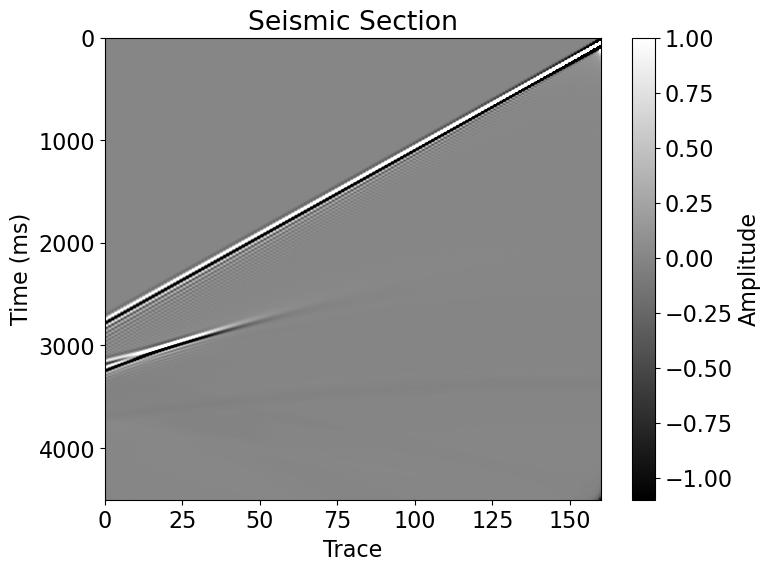

In [50]:
from examples.seismic.acoustic import AcousticWaveSolver

solver = AcousticWaveSolver(model, geometrys[0], space_order=4)

d_obs = Receiver(name='d_obs', grid=model.grid,
                         time_range=geometrys[0].time_axis, 
                         coordinates=geometrys[0].rec_positions)

_, _, _ = solver.forward(vp=model0.vp, src=srcs[0], rec=d_obs)

plt.imshow(d_obs.data, aspect='auto', cmap='gray', extent=[0, 160, 4504, 0], vmax=-1, vmin=1)
plt.xlabel('Trace')
plt.ylabel('Time (ms)')
plt.title('Seismic Section')
plt.colorbar(label='Amplitude')
plt.show()

In [ ]:
from examples.seismic.acoustic import AcousticWaveSolver

solver = AcousticWaveSolver(model, geometrys[0], space_order=4)

d_obs = Receiver(name='d_obs', grid=model.grid,
                         time_range=geometrys[0].time_axis, 
                         coordinates=geometrys[0].rec_positions)

_, _, _ = solver.forward(vp=update_model.vp, src=srcs[0], rec=d_obs)

plt.imshow(d_obs.data, aspect='auto', cmap='gray', extent=[0, 160, 4504, 0], vmax=-1, vmin=1)
plt.xlabel('Trace')
plt.ylabel('Time (ms)')
plt.title('Seismic Section')
plt.colorbar(label='Amplitude')
plt.show()